In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu
from scipy import stats
from tqdm.auto import tqdm
from scipy.stats import norm

%matplotlib inline 

In [2]:
active_users    = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-lesihina/Final_project/Проект_4_active_users.csv')
groups          = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-lesihina/Final_project/Проект_4_groups.csv')
purchases       = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-lesihina/Final_project/Проект_4_purchases.csv')

In [3]:
active_users

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male
...,...,...,...,...
8336,2417,Sweden,ios,female
8337,3755,Russia,ios,male
8338,4594,Sweden,android,female
8339,7430,Sweden,ios,female


In [4]:
active_users.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


# Объединим все данные

Объединим таблицу с **пользователями** и таблицу с заказами

In [5]:
join_users_purchases = active_users[['user_id','country','platform','sex']].merge(purchases[['user_id','revenue']],
                                                                                  how = 'left', on = 'user_id')

In [6]:
all = join_users_purchases[['user_id','country','platform','sex','revenue']].merge(groups[['user_id','group']],
                                                                                  how = 'left', on = 'user_id')

In [7]:
all

,user_id,country,platform,sex,revenue,group
0,8029,Russia,ios,male,NaN,B
1,1735,Sweden,ios,male,NaN,B
2,7697,Russia,android,male,NaN,B
3,1421,Sweden,android,female,NaN,B
4,1704,Russia,ios,male,NaN,B
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,NaN,B
8337,3755,Russia,ios,male,590.0,A
8338,4594,Sweden,android,female,NaN,B
8339,7430,Sweden,ios,female,NaN,B


In [8]:
all['group'].value_counts()

B    6803
A    1538
Name: group, dtype: int64

#### Задание 1
Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обосновать выбор метрик, на которые обращаете внимание. 
Если различия есть, то объяснить, с чем они могут быть связаны и являются ли значимыми.

# Посмотрим статистику

In [9]:
all[['group','country','platform','sex']].value_counts()

group  country  platform  sex   
B      Russia   android   male      1268
                          female    1210
                ios       female    1013
                          male      1001
       Sweden   android   female     662
                          male       647
                ios       female     507
                          male       495
A      Russia   android   female     267
                          male       243
                ios       male       231
                          female     174
       Sweden   android   male       162
                          female     162
                ios       female     150
                          male       149
dtype: int64

#### Посмотрим на гистограмму по всем оплатам

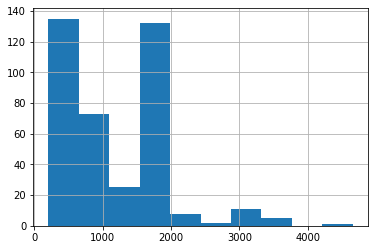

In [12]:
all['revenue'].hist()

#### Посмотрим разбивку по странам

In [14]:
all.groupby(['group', 'country']).agg({'revenue':'mean'})

revenue
group country             
A     Russia    823.418605
      Sweden   1091.171429
B     Russia   1215.441624
      Sweden   1356.162393

#### Средний доход и в тестовой и контрольной выше в Швеции

In [17]:
# Заполним пустые значения и отберем только те,что выше нуля
all['revenue'] = all['revenue'].fillna(0)
all_full = all.query('revenue != 0')
all_full.head()

,user_id,country,platform,sex,revenue,group
45,1202,Sweden,android,male,302.0,A
58,6284,Russia,android,female,208.0,B
63,6554,Sweden,android,female,602.0,B
101,6000,Sweden,ios,male,1910.0,B
117,4046,Sweden,ios,female,1909.0,B


In [19]:
# Посмотрим на среднее значение (выше нуля)
all\
    .query ('revenue != 0')\
    .groupby ('group')\
    .agg ({'revenue':'mean'})

,revenue
group,
A,943.564103
B,1267.875796


In [21]:
# Посмотрим на медиану
all\
    .query ('revenue != 0')\
    .groupby ('group')\
    .agg ({'revenue':'median'})

,revenue
group,
A,596.0
B,1151.0


В качестве метрик будем разбирать средний доход на пользователя, средний доход на платящего пользователя и конверсию посещений. 

ARPPU покажет средние траты только платящих
ARPU покажет средние траты клиента на проудукт
Conversion Rate покажет изменения посещаемсти для тестовой и контрольной группы

In [23]:
ARPU_A = all.query('group == "A"').revenue.sum() / all.query('group == "A"').shape[0]
ARPU_B = all.query('group == "B"').revenue.sum() / all.query('group == "B"').shape[0]

print('ARPU контрольная = ', '%.2f' % ARPU_A)
print('ARPU тестовая = ', '%.2f' % ARPU_B)

ARPU контрольная =  47.85
ARPU тестовая =  58.52


In [24]:
CR_A = ((all.query('group == "A" and revenue > 0').user_id.nunique() / all.query('group == "A"').user_id.nunique())*100)
CR_B = (all.query('group == "B" and revenue > 0').user_id.nunique() / all.query('group == "B"').user_id.nunique())*100

print('CR контрольная = ', '%.2f' % CR_A)
print('CR тестовая = ', '%.2f' % CR_B)

CR контрольная =  5.07
CR тестовая =  4.62


In [25]:
ARPPU_A = all.query('group == "A"').revenue.sum() / all.query('group == "A" and revenue > 0').shape[0]
ARPPU_B = all.query('group == "B"').revenue.sum() / all.query('group == "B" and revenue > 0').shape[0]

print('ARPPU контрольная = ', '%.2f' % ARPPU_A)
print('ARPPU тестовая = ', '%.2f' % ARPPU_B)

ARPPU контрольная =  943.56
ARPPU тестовая =  1267.88


# Мини вывод:

Тестовая группа показывает больший средний доход с одного посетителя и с платящего клианта, но меньшую конверсию.

Можем предположить, что изменения благоприятно влияют на целевую аудиторию и стимулируют к бОльшим тратам.

### Сделаем более глубокий анализ. Посмотрим с разбивкой по стране, устройству и полу.

## ARPU

### ARPU по странам 

In [28]:
ARPU_A_Russia = all.query('group == "A" and country == "Russia"').revenue.sum() / all.query('group == "A" and revenue > 0 and country == "Russia"').shape[0]
ARPU_B_Russia = all.query('group == "B" and country == "Russia"').revenue.sum() / all.query('group == "B" and revenue > 0 and country == "Russia"').shape[0]
ARPU_A_Sweden = all.query('group == "A" and country == "Sweden"').revenue.sum() / all.query('group == "A" and revenue > 0 and country == "Sweden"').shape[0]
ARPU_B_Sweden = all.query('group == "B" and country == "Sweden"').revenue.sum() / all.query('group == "B" and revenue > 0 and country == "Sweden"').shape[0]

print('ARPU контрольной Russia = ', '%.2f' % ARPU_A_Russia)
print('ARPU тестовой Russia = ', '%.2f' % ARPU_B_Russia)
print('ARPU контрольной Sweden = ', '%.2f' % ARPU_A_Sweden)
print('ARPU тестовой Sweden = ', '%.2f' % ARPU_B_Sweden)

ARPU контрольной Russia =  823.42
ARPU тестовой Russia =  1215.44
ARPU контрольной Sweden =  1091.17
ARPU тестовой Sweden =  1356.16


### ARPU по устройствам

In [30]:
ARPU_A_Android = all.query('group == "A" and platform == "android"').revenue.sum() / all.query('group == "A" and revenue > 0 and platform == "android"').shape[0]
ARPU_B_Android = all.query('group == "B" and platform == "android"').revenue.sum() / all.query('group == "B" and revenue > 0 and platform == "android"').shape[0]
ARPU_A_Ios = all.query('group == "A" and  platform == "ios"').revenue.sum() / all.query('group == "A" and revenue > 0 and platform == "ios"').shape[0]
ARPU_B_Ios = all.query('group == "B" and  platform == "ios"').revenue.sum() / all.query('group == "B" and revenue > 0 and platform == "ios"').shape[0]

print('ARPU контрольная Android = ', '%.2f' % ARPU_A_Android)
print('ARPU тестовая Android = ', '%.2f' % ARPU_B_Android)
print('ARPU контрольная iOs = ', '%.2f' % ARPU_A_Ios)
print('ARPU тестовая iOs = ', '%.2f' % ARPU_B_Ios)

ARPU контрольная Android =  1023.03
ARPU тестовая Android =  1232.44
ARPU контрольная iOs =  864.10
ARPU тестовая iOs =  1309.18


Видим подтверждение ранее полученных результатов. Плюс по iOS отличие больше, чем в 1,5 раза

### ARPU по полу

In [33]:
ARPU_A_male = all.query('group == "A" and sex == "male"').revenue.sum() / all.query('group == "A" and revenue > 0 and sex == "male"').shape[0]
ARPU_B_male = all.query('group == "B" and sex == "male"').revenue.sum() / all.query('group == "B" and revenue > 0 and sex == "male"').shape[0]
ARPU_A_female = all.query('group == "A" and sex == "female"').revenue.sum() / all.query('group == "A" and revenue > 0 and sex == "female"').shape[0]
ARPU_B_female = all.query('group == "B" and sex == "female"').revenue.sum() / all.query('group == "B" and revenue > 0 and sex == "female"').shape[0]

print('ARPU контрольная М = ', '%.2f' % ARPU_A_male)
print('ARPU тестовая М = ', '%.2f' % ARPU_B_male)
print('ARPU контрольная Ж = ', '%.2f' % ARPU_A_female)
print('ARPU тестовая Ж = ', '%.2f' % ARPU_B_female)

ARPU контрольная М =  1021.73
ARPU тестовая М =  1169.37
ARPU контрольная Ж =  856.95
ARPU тестовая Ж =  1370.22


Видим подтверждение ранее полученных результатов. Плюс по женщинам отличие больше, чем в 1,5 раза

## CR

### CR по странам

In [36]:
CR_A_Russia = (all.query('group == "A" and revenue > 0 and country == "Russia"').user_id.nunique() / all.query('group == "A" and country == "Russia"').user_id.nunique())*100
CR_B_Russia = (all.query('group == "B" and revenue > 0 and country == "Russia"').user_id.nunique() / all.query('group == "B" and country == "Russia"').user_id.nunique())*100
CR_A_Sweden = (all.query('group == "A" and revenue > 0 and country == "Sweden"').user_id.nunique() / all.query('group == "A" and country == "Sweden"').user_id.nunique())*100
CR_B_Sweden = (all.query('group == "B" and revenue > 0 and country == "Sweden"').user_id.nunique() / all.query('group == "B" and country == "Sweden"').user_id.nunique())*100

print('CR контрольная Россия  = ', '%.2f' % CR_A_Russia, '%')
print('CR тестовая Россия = ', '%.2f' % CR_B_Russia, '%')
print('CR контрольная Швеция = ', '%.2f' % CR_A_Sweden, '%')
print('CR тестовая Швеция = ', '%.2f' % CR_B_Sweden, '%')

CR контрольная Россия  =  4.70 %
CR тестовая Россия =  4.39 %
CR контрольная Швеция =  5.62 %
CR тестовая Швеция =  5.06 %


### CR по устройствам

In [38]:
CR_A_Android = (all.query('group == "A" and revenue > 0 and platform == "android"').user_id.nunique() / all.query('group == "A" and platform == "android"').user_id.nunique())*100
CR_B_Android = (all.query('group == "B" and revenue > 0 and platform == "android"').user_id.nunique() / all.query('group == "B" and platform == "android"').user_id.nunique())*100
CR_A_Ios = (all.query('group == "A" and revenue > 0 and platform == "ios"').user_id.nunique() / all.query('group == "A" and platform == "ios"').user_id.nunique())*100
CR_B_Ios = (all.query('group == "B" and revenue > 0 and platform == "ios"').user_id.nunique() / all.query('group == "B" and platform == "ios"').user_id.nunique())*100

print('CR контрольная Android = ', '%.2f' % CR_A_Android, '%')
print('CR тестовая Android = ', '%.2f' % CR_B_Android, '%')
print('CR контрольная iOs = ', '%.2f' % CR_A_Ios, '%')
print('CR тестовая iOs = ', '%.2f' % CR_B_Ios, '%')

CR контрольная Android =  4.68 %
CR тестовая Android =  4.46 %
CR контрольная iOs =  5.54 %
CR тестовая iOs =  4.81 %


### CR по полу

In [40]:
CR_A_male = (all.query('group == "A" and revenue > 0 and sex == "male"').user_id.nunique() / all.query('group == "A" and sex == "male"').user_id.nunique())*100
CR_B_male = (all.query('group == "B" and revenue > 0 and sex == "male"').user_id.nunique() / all.query('group == "B" and sex == "male"').user_id.nunique())*100
CR_A_female = (all.query('group == "A" and revenue > 0 and sex == "female"').user_id.nunique() / all.query('group == "A" and sex == "female"').user_id.nunique())*100
CR_B_female = (all.query('group == "B" and revenue > 0 and sex == "female"').user_id.nunique() / all.query('group == "B" and sex == "female"').user_id.nunique())*100

print('CR контрольная М = ', '%.2f' % CR_A_male, '%')
print('CR тестовая М = ', '%.2f' % CR_B_male, '%')
print('CR контрольная Ж = ', '%.2f' % CR_A_female, '%')
print('CR тестовая Ж = ', '%.2f' % CR_B_female, '%')

CR контрольная М =  5.22 %
CR тестовая М =  4.69 %
CR контрольная Ж =  4.91 %
CR тестовая Ж =  4.54 %


## ARPPU

### ARPPU по полу

In [42]:
ARPPU_A_male = all.query('group == "A" and sex == "male"').revenue.sum() / all.query('group == "A" and revenue > 0 and sex == "male"').shape[0]
ARPPU_B_male = all.query('group == "B" and sex == "male"').revenue.sum() / all.query('group == "B" and revenue > 0 and sex == "male"').shape[0]
ARPPU_A_fem = all.query('group == "A" and sex == "female"').revenue.sum() / all.query('group == "A" and revenue > 0 and sex == "female"').shape[0]
ARPPU_B_fem = all.query('group == "B" and sex == "female"').revenue.sum() / all.query('group == "B" and revenue > 0 and sex == "female"').shape[0]

print('ARPPU контрольная М = ', '%.2f' % ARPPU_A_male)
print('ARPPU тестовая М = ', '%.2f' % ARPPU_B_male)
print('ARPPU контрольная Ж = ', '%.2f' % ARPPU_A_fem)
print('ARPPU тестовая Ж = ', '%.2f' % ARPPU_B_fem)

ARPPU контрольная М =  1021.73
ARPPU тестовая М =  1169.37
ARPPU контрольная Ж =  856.95
ARPPU тестовая Ж =  1370.22


### ARPPU по стране

In [44]:
ARPPU_A_rus = all.query('group == "A" and country == "Russia"').revenue.sum() / all.query('group == "A" and revenue > 0 and country == "Russia"').shape[0]
ARPPU_B_rus = all.query('group == "B" and country == "Russia"').revenue.sum() / all.query('group == "B" and revenue > 0 and country == "Russia"').shape[0]
ARPPU_A_swd = all.query('group == "A" and country == "Sweden"').revenue.sum() / all.query('group == "A" and revenue > 0 and country == "Sweden"').shape[0]
ARPPU_B_swd = all.query('group == "B" and country == "Sweden"').revenue.sum() / all.query('group == "B" and revenue > 0 and country == "Sweden"').shape[0]

print('ARPPU контрольная Россия = ', '%.2f' % ARPPU_A_rus)
print('ARPPU тестовая Россия = ', '%.2f' % ARPPU_B_rus)
print('ARPPU контрольная Швеция = ', '%.2f' % ARPPU_A_swd)
print('ARPPU тестовая Швеция = ', '%.2f' % ARPPU_B_swd)

ARPPU контрольная Россия =  823.42
ARPPU тестовая Россия =  1215.44
ARPPU контрольная Швеция =  1091.17
ARPPU тестовая Швеция =  1356.16


### ARPPU по устрйоствам

In [46]:
ARPPU_A_Android = all.query('group == "A" and platform == "android"').revenue.sum() / all.query('group == "A" and revenue > 0 and platform == "android"').shape[0]
ARPPU_B_Android = all.query('group == "B" and platform == "android"').revenue.sum() / all.query('group == "B" and revenue > 0 and platform == "android"').shape[0]
ARPPU_A_iOs = all.query('group == "A" and platform == "ios"').revenue.sum() / all.query('group == "A" and revenue > 0 and platform == "ios"').shape[0]
ARPPU_B_iOs = all.query('group == "B" and platform == "ios"').revenue.sum() / all.query('group == "B" and revenue > 0 and platform == "ios"').shape[0]

print('ARPPU контрольная андроид = ', '%.2f' % ARPPU_A_Android)
print('ARPPU тестовая андроид = ', '%.2f' % ARPPU_B_Android)
print('ARPPU контрольная iOs = ', '%.2f' % ARPPU_A_iOs)
print('ARPPU тестовая iOs = ', '%.2f' % ARPPU_B_iOs)

ARPPU контрольная андроид =  1023.03
ARPPU тестовая андроид =  1232.44
ARPPU контрольная iOs =  864.10
ARPPU тестовая iOs =  1309.18


## Мини вывод

Более детальное рассмотрение критериев показывает нам схожую ситуацию с различием показателей в тестовой и контрольной группе.

## Проверим распределение и наши результаты

Еще раз подтвердим, что распределение не нормальное с помощью теста Шапиро.

In [50]:
stats.shapiro(all[all['group'] == 'A']['revenue'].sample(1500, random_state=17))

ShapiroResult(statistic=0.15433555841445923, pvalue=0.0)

По графику выше и по результатам теста видим,что распределение не нормальное + длинные выбросы, 
поэтому будем использовать тест Манна-Уитни.

Возьмем нулевую гипотезу о том,что статистических различий по оплате и среднему чеку нет.
H1 - стат различия есть между тестом и контрольной.

In [53]:
# Применим тест Манна Уитни,чтобы принять/отклонить нудевую гипотезу
stats.mannwhitneyu(all.query('group == "A" and revenue > 0').revenue, all.query('group == "B" and revenue > 0').revenue)

MannwhitneyuResult(statistic=8961.0, pvalue=0.00023939080114586078)

p-value меньше 0,05 Поэтому H0 можем отклонить

Также проверим по разбивкам выше

## Проводим тест Манна-Уитни

### Манн-Утни с учетом стран

In [56]:
Rus = stats.mannwhitneyu(all.query('group == "A" and revenue > 0 and country == "Russia"').revenue, all.query('group == "B" and revenue > 0 and country == "Russia"').revenue)
Swe = stats.mannwhitneyu(all.query('group == "A" and revenue > 0 and country == "Sweden"').revenue, all.query('group == "B" and revenue > 0 and country == "Sweden"').revenue)

print('Тест Манна-Уитни по России: ', Rus)
print('Тест Манна-Уитни по Швеции: ', Swe)

Тест Манна-Уитни по России:  MannwhitneyuResult(statistic=2925.5, pvalue=0.0014699816493472517)
Тест Манна-Уитни по Швеции:  MannwhitneyuResult(statistic=1577.5, pvalue=0.03958280081671394)


### Манн-Утни с учетом пола

In [58]:
Fem = stats.mannwhitneyu(all.query('group == "A" and revenue > 0 and sex == "female"').revenue, all.query('group == "B" and revenue > 0 and sex == "female"').revenue)
Man = stats.mannwhitneyu(all.query('group == "A" and revenue > 0 and sex == "male"').revenue, all.query('group == "B" and revenue > 0 and sex == "male"').revenue)

print('Тест Манна-Уитни по Ж: ', Fem)
print('Тест Манна-Уитни по М: ', Man)

Тест Манна-Уитни по Ж:  MannwhitneyuResult(statistic=1841.0, pvalue=0.0008191912980826493)
Тест Манна-Уитни по М:  MannwhitneyuResult(statistic=2663.0, pvalue=0.06326402745293058)


### Манн-Утни с учетом типа устройства

In [60]:
And = stats.mannwhitneyu(all.query('group == "A" and revenue > 0 and platform == "android"').revenue, all.query('group == "B" and revenue > 0 and platform == "android"').revenue)
IOS = stats.mannwhitneyu(all.query('group == "A" and revenue > 0 and platform == "ios"').revenue, all.query('group == "B" and revenue > 0 and platform == "ios"').revenue)

print('Тест Манна-Уитни по Андроиду: ', And)
print('Тест Манна-Уитни по iOs: ', IOS)

Тест Манна-Уитни по Андроиду:  MannwhitneyuResult(statistic=2630.0, pvalue=0.04925014637316891)
Тест Манна-Уитни по iOs:  MannwhitneyuResult(statistic=1893.5, pvalue=0.0015426543641399385)


По результатам тестов Манна Уитни на разбивках мы получаем практически те же результаты, как и на общем тесте.
Принять H0 можно только на разбивках по полу (у мужчин).

Как результат: Разница в контрольной и тесте по revenue есть. Наши подсчета ARPU и CR можно считать статистически значимыми.
Поэтому - в тесте ARPU выше, чем в контроле. Соответственно обновления можно применить на все приложение.

Предположиельно обновления лучше всего повлияют на пользователей iOs и на женщин.

## Теперь оценим значимость различий с помощью бутстрапа

In [62]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [63]:
revenue_control = all.query('group == "A" and revenue > 0').revenue
revenue_test = all.query('group == "B" and revenue > 0').revenue

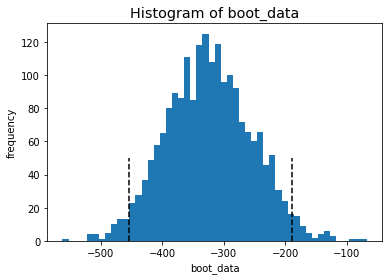

2.8934154005728713e-06

In [64]:
booted_data = get_bootstrap(revenue_control, revenue_test, boot_it = 2000, statistic = np.mean)
booted_data['p_value']

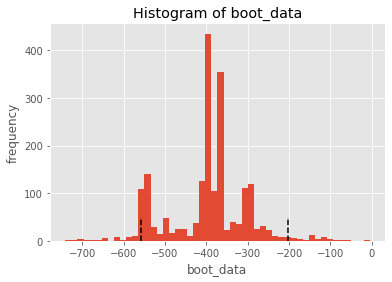

3.1383146702599e-05

In [35]:
booted_data = get_bootstrap(revenue_control, revenue_test, boot_it = 2000, statistic = np.median)
booted_data['p_value']

## Проверим ARPU

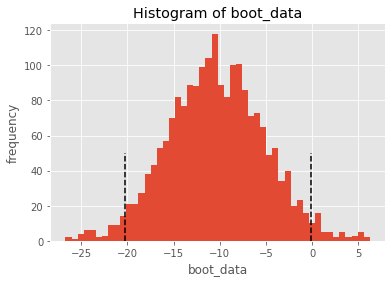

0.04534106011934894

In [36]:
check_ARPU = get_bootstrap(all.query('group == "A"').revenue, all.query('group == "B"').revenue, boot_it=2000, statistic = np.mean)
check_ARPU['p_value']

Так как значение p_value < 0.05, то мы можем отвергнуть нулевую гипотезу, и сделать вывод, что ARPU в тестовой выборке больше, чем ARPU в контрольной.

## Проверим ARPPU

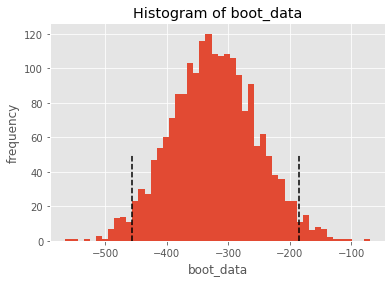

3.140616093224576e-06

In [37]:
check_ARPPU = get_bootstrap(all.query('group == "A" and revenue > 0').revenue,all.query('group == "B" and revenue > 0').revenue, boot_it=2000, statistic = np.mean)
check_ARPPU["p_value"]

Видим аналогичную ситуацию. Вывод: ARPPU в тестовой выборке больше, чем ARPPU в контрольной

### Общие выводы:

Мы сделали 2 проверки (Тест Манна Уитни и Бутстрап) и обе показали, что у нас есть положительные статистически значимые различия между тестовой и контрольной группой.

Изменения можно выкатывать на все приложение.

In [38]:
# Задание 2 

all.to_csv('all.csv')

In [ ]:
# Ссылка на дашборд: 
# https://public.tableau.com/app/profile/alena8478/viz/Final_project_16581754012100/Dashboard1?publish=yes